In [1]:
# pip install pandas scikit-learn matplotlib

In [2]:
from pathlib import Path
import os

import utils as u

In [3]:
notebook_path = Path(os.path.abspath("."))
data_path = notebook_path.parent / "docs" / "data"

# EVALUATION

## NHL

In [4]:
prediction_files, results_files = u.get_prediction_results_filepaths(league="nhl", root=data_path)

df = u.make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=6.5, hcp_line=1.5)
df.head(2)

,match_id,start_time_utc,home_team,away_team,ft_home_prob,ou_prob,hcp_prob,home_team_score,away_team_score,ft_home_won,ou_won,hcp_won
0,2025020522,2025-12-17T00:00:00,Detroit Red Wings,New York Islanders,0.5460,0.4406,0.7686,3,2,True,False,True
1,2025020338,2025-11-23T00:00:00,Florida Panthers,Edmonton Oilers,0.5131,0.4313,0.7395,3,6,False,True,False


=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          582      0.5292 0.2554   0.7042 0.5073   0.5120
Totals (Over/Under)  582      0.4742 0.2503   0.6938 0.5171   0.5189
Asian Handicap       582      0.7440 0.1932   0.5758 0.5337   0.7423


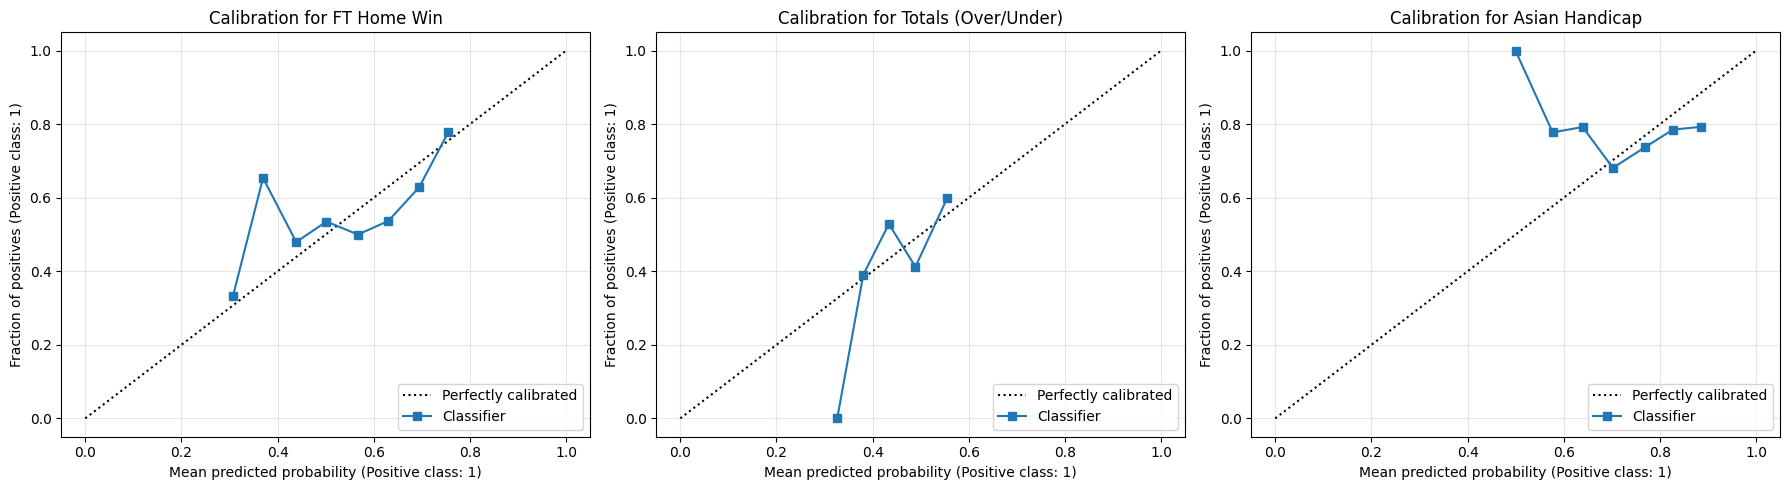

In [5]:
# Evaluate everything
_ = u.evaluate_calibration(df=df, n_bins=15)

=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          442      0.5294 0.2538   0.7006 0.5153   0.5090
Totals (Over/Under)  442      0.4751 0.2503   0.6937 0.5241   0.5068
Asian Handicap       442      0.7398 0.1959   0.5811 0.5282   0.7376


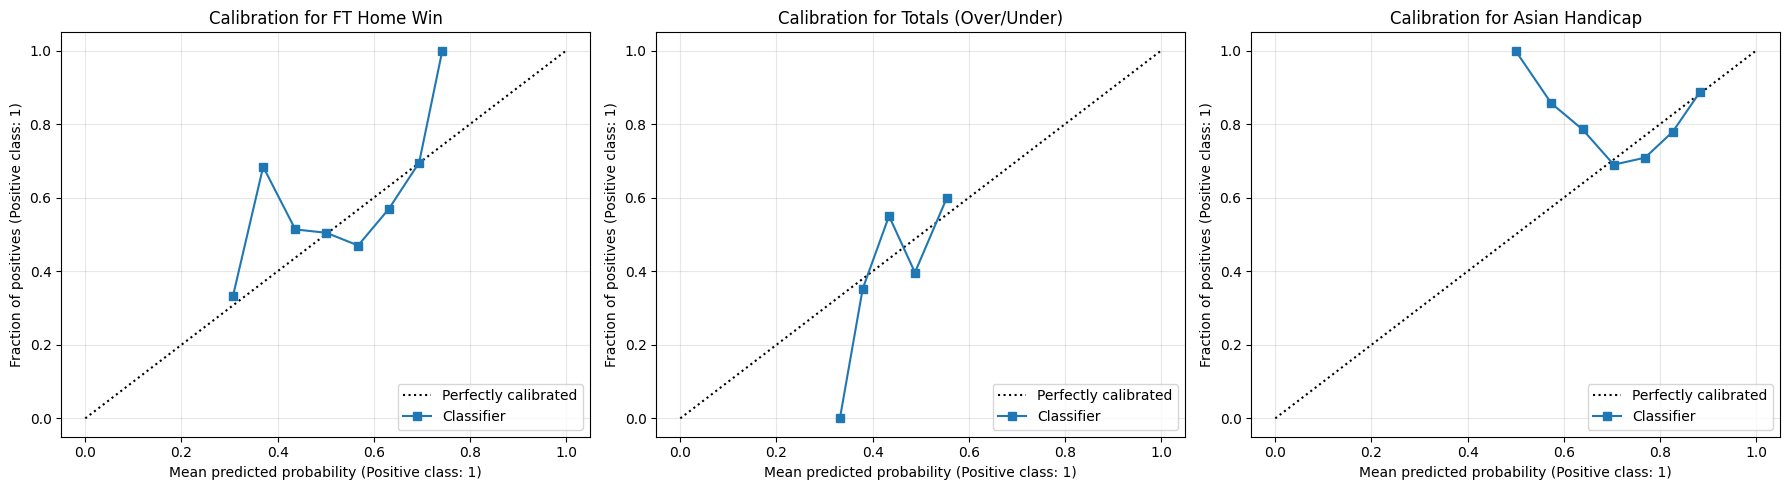

In [6]:
# Evaluate matches only after major bugfix
after_bug_df = df[df["start_time_utc"]>="2025-10-29 15:00:00"].copy()
_ = u.evaluate_calibration(df=after_bug_df, n_bins=15)

## NBA

In [7]:
prediction_files, results_files = u.get_prediction_results_filepaths(league="nba", root=data_path)

df = u.make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=225.5, hcp_line=8.5)
df.head(2)

,match_id,start_time_utc,home_team,away_team,ft_home_prob,ou_prob,hcp_prob,home_team_score,away_team_score,ft_home_won,ou_won,hcp_won
0,0022500264,2025-11-21T00:00:00,Orlando Magic,Los Angeles Clippers,0.3465,0.3498,0.5706,129,101,True,True,True
1,0022500521,2026-01-08T00:30:00,Brooklyn Nets,Orlando Magic,0.7966,0.5374,0.9183,103,104,False,False,True


=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          307      0.5570 0.2313   0.6575 0.6601   0.6254
Totals (Over/Under)  307      0.5733 0.2549   0.7102 0.6072   0.5733
Asian Handicap       307      0.7557 0.1724   0.5198 0.6893   0.7427


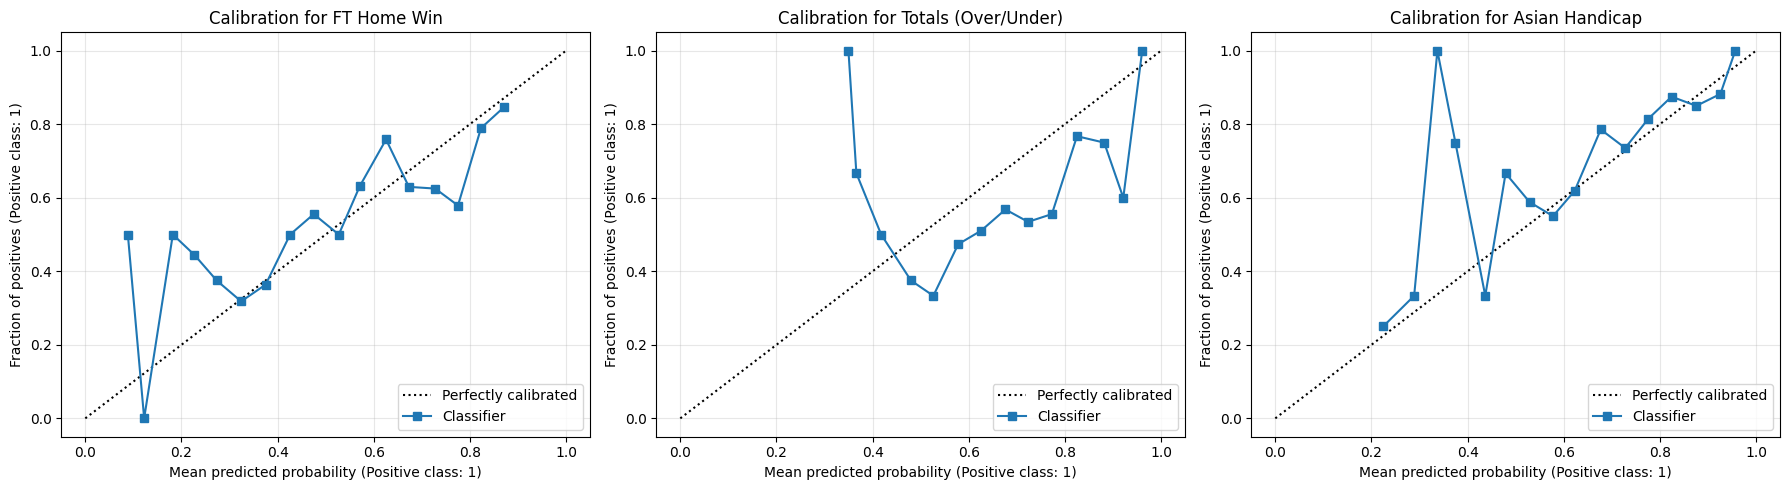

In [8]:
_ = u.evaluate_calibration(df=df, n_bins=20)